In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from drawnow import drawnow,figure
from IPython.core.display import HTML
from IPython import display

For interference between two waves, there's a nice closed form for the measured intensity. 

Use two waves: the reference wave denoted $U_r = A_r \exp(\phi_r(x,y,z))$, and the object wave denoted $U_i = A_i \exp(\phi_i(x,y,z))$.

At the sensor plane $z=0$, the field will be the sum: $$U_s = U_r+U_i = A_r \exp(\phi_r(x,y,z)) + A_i \exp(\phi_i(x,y,z))$$

The intensity will then be $|U_s|^2 = |U_r+U_i|^2 = (U_r^* + U_i^*)(U_r + U_i)$ where $^*$ denotes complex conjugation.

Multiplying this out, we get the intensity at the sensor:
$$I_s = |A_r|^2 + |A_i|^2 + |A_r||A_s|\left(\exp(\phi_r-\phi_i) + \exp(-\phi_r + \phi_i)\right)$$
$$=|A_r|^2 + |A_i|^2 + 2|A_r||A_s|\cos \left(\phi_r-\phi_i\right)$$

So for the simple case of a plane wave scattering from a single point, we can approximate this as the sum of a plane wave and a spherical wave scattered from the point. The plane wave component will be treated as the reference wave. It's phase will be $\phi_r = kz_i$, where $k=\frac{2\pi}{\lambda}$. The scattered wave will have a spherical phase centered at $(x_i,y_i,z_i)$, which is written as $kz_i\sqrt{1+\frac{(x-x_i)^2}{z_i^2}+\frac{(y-y_i)^2}{z_i^2}}$

Hence the intensity has a nice closed form of 
$$I_s = I_r + I_i + 2\sqrt{I_r}\sqrt{I_i}cos\left[kz_i\left(1-\sqrt{1+\frac{(x-x_i)^2}{z_i^2}+\frac{(y-y_i)^2}{z_i^2}}\right) + \phi\right]$$

This assumes no angular falloff at the sensor. Realistically, it would be goot to capture this in an amplitude term that is spatially varying such that $I_i$ is a function of $(x,y)$.

In [17]:
# Preliminary system params
lam = 633e-9   #Work in m
k = 2*np.pi/lam   #Magnitude of k-vector
z = -10e-3   #Plane of sensor
px = .5e-6;    #Pixel size in m
M = 2048;    #Number of sensor rows (y)
N = 2560;    #Number of sensor columns (x)
y = (np.r_[0:M] - M/2) * px    #y grid
x = (np.r_[0:N] - N/2) * px    #x grid
xi = -.1e-3;
yi = .01e-3
X,Y = np.meshgrid(x,y)    #Meshgrid to get 2D-plaid variables


# Setup phase of each wave
phase_ref = k*z;
phase_obj = k*z*np.sqrt(1 + ((X-xi)/z)**2 + ((Y-yi)/z)**2);
Ir = 1;
Ii = 1;
phirand = np.random.rand(1)*2*np.pi*0;
Is = Ir + Ii + np.sqrt(Ii)*np.sqrt(Ir)*np.cos(phirand + phase_ref - phase_obj);

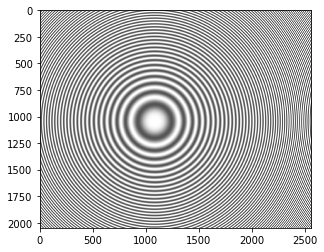

In [18]:
plt.imshow(Is,vmin=0,cmap='gray')


Check for redundancy. We want to know which points in the scene will produce identical measurements. I think this will happen when $\phi_r - \phi_i=c$ where $c$. Assuming the phase of the scattering is unknown, we'd normally localize something in xyz from the bullseye above by finding the (x,y) center of the pattern, then fitting to the locations of the fringes to estimate depth. If we knew exactly the phase of each particle, perhaps we could fix this?

Anyway, the condition I'm worried about is when we slice this bullseye as in sampling with rolling shutter. 

We'll get:
$$I_s = I_r + I_i + 2\sqrt{I_i}\sqrt{I_r}\int_{-\infty}^\infty \cos\left[\Delta \phi\right]\delta(y) dy$$
$$=I_s = I_r + I_i + 2\sqrt{I_i}\sqrt{I_r}\cos\left[\Delta \phi(x,y=0;x_i,y_i,z_i))\right]$$

Looking just at the phase difference term, we get
$$\Delta \phi(x,y=0;x_i,y_i,z_i) = kz_i - k\sqrt{z_i^2 + (x-x_i)^2 + y_i^2}$$

So from this 1D profile, how well can we estimate parameters $x_i$, $y_i$, and $z_i$? If the spherical phase term is ever the same for two points in the scene, we're in trouble. So we can ask when does $z_i^2 + (x-x_i)^2 + y_i^2 = b$? This is when $y_i^2 = b - (x-x_i)^2 - z_i^2$. So the concern is that there's a set of redundant locations in the scene where, up to a constant (and likely hard to estimate) phase value, we get the same measurememts. Let's try it out!


<Figure size 432x288 with 0 Axes>

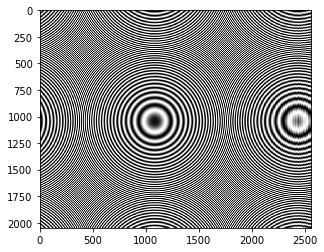

In [7]:
plt.figure()
U_obj = np.exp(1j*phase_obj)
I_nophase = np.abs(U_obj + np.conj(U_obj))**2
plt.figure()
plt.imshow(np.real(I_nophase), vmin=0, cmap='gray')


In [8]:

# z = -10e-3   #Plane of sensor
# z_vec = np.linspace(0,.2,10)
# b = .1;
   
# f = plt.figure()    
# for z0 in z_vec:
#     xi = -.1e-3;
#     yi = np.sqrt(b - z0**2);


#     # Setup phase of each wave
#     phase_ref = k*z;
#     phase_obj = k*z*np.sqrt(1 + ((x-xi)/z)**2 + (yi/z)**2);
#     Ir = 1;
#     Ii = .5;
#     phirand = k*z0
#     Is = Ir + Ii + np.sqrt(Ii)*np.sqrt(Ir)*np.cos(phirand + phase_ref - phase_obj);
#     plt.plot(Is)
#     display.display(f)
#     display.clear_output(wait=True)